<a href="https://colab.research.google.com/github/davidbro-in/pds-fir-pipeline/blob/main/notebooks/fir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     |████████████████████████████████| 339 kB 5.0 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=ac1ff342feeaec3e067f07ac828ec2a755f0315d46a0928ca94527f978f572fc
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


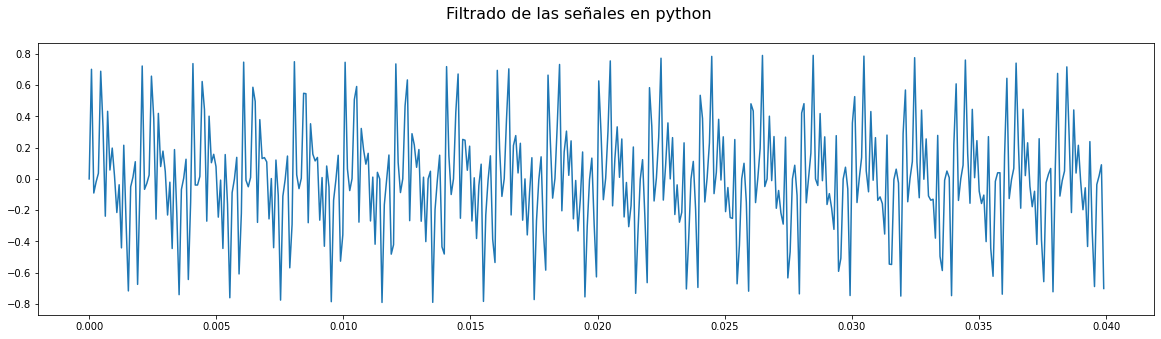

In [7]:
import numpy as np
import matplotlib.pyplot as plt
!pip3 install control
import control


fs = 11025
sec = 0.04
t = np.arange(0, fs*sec, 1)/fs

# Tonos generados a inyectar al sistema de filtrado
tones = (np.sin(2*np.pi * 500 *t) + np.sin(2*np.pi * 2500 *t) + np.sin(2*np.pi * 3000 *t) + np.sin(2*np.pi * 4500 *t))/4

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Filtrado de las señales en python", fontsize=16)
signalAxes, = plt.plot(t, tones)

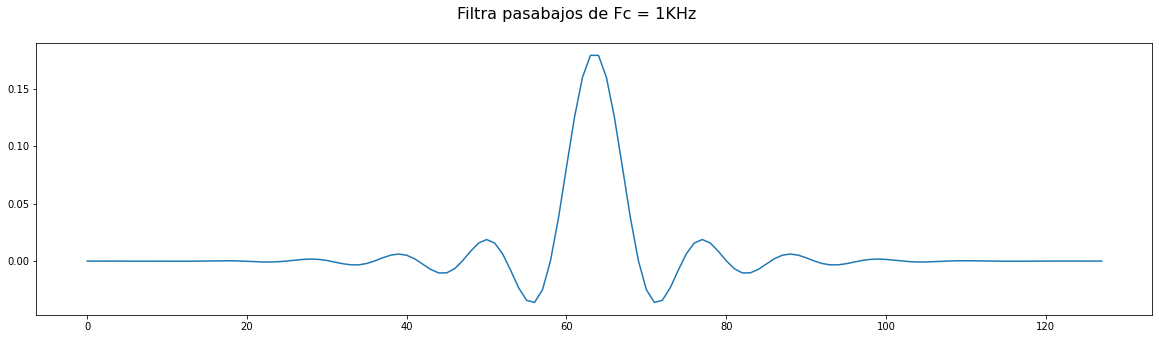

In [8]:
lowpass = [-0,-0,-0,0,0,3.052e-05,3.052e-05,3.052e-05,0,-3.052e-05,-6.104e-05,-9.155e-05,-0.0001221,-9.155e-05,0,0.0001526,0.0002747,0.0003357,0.0003052,0.0001221,-0.0001831,-0.0005188,-0.0007629,-0.0007935,-0.0005188,6.104e-05,0.0007935,0.001465,0.00177,0.001465,0.0005493,-0.000824,-0.002289,-0.003235,-0.003265,-0.002075,0.0001526,0.002899,0.005188,0.006134,0.005096,0.001953,-0.002625,-0.007233,-0.01025,-0.01025,-0.006561,0.0003052,0.008606,0.01569,0.01874,0.01575,0.006317,-0.007843,-0.02301,-0.03409,-0.03595,-0.02487,0.0003967,0.03769,0.0817,0.125,0.1597,0.1789,0.1789,0.1597,0.125,0.0817,0.03769,0.0003967,-0.02487,-0.03595,-0.03409,-0.02301,-0.007843,0.006317,0.01575,0.01874,0.01569,0.008606,0.0003052,-0.006561,-0.01025,-0.01025,-0.007233,-0.002625,0.001953,0.005096,0.006134,0.005188,0.002899,0.0001526,-0.002075,-0.003265,-0.003235,-0.002289,-0.000824,0.0005493,0.001465,0.00177,0.001465,0.0007935,6.104e-05,-0.0005188,-0.0007935,-0.0007629,-0.0005188,-0.0001831,0.0001221,0.0003052,0.0003357,0.0002747,0.0001526,0,-9.155e-05,-0.0001221,-9.155e-05,-6.104e-05,-3.052e-05,0,3.052e-05,3.052e-05,3.052e-05,0,0,-0,-0,-0]

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Filtra pasabajos de Fc = 1KHz", fontsize=16)
signalAxes, = plt.plot(lowpass)

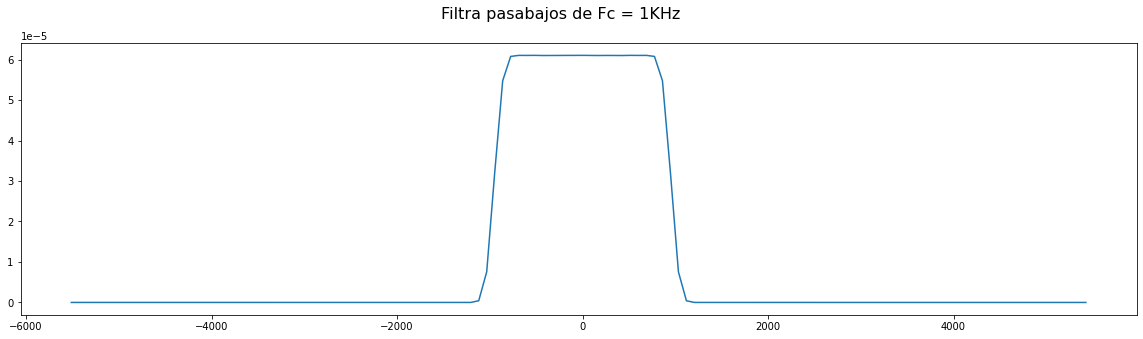

In [27]:
HData  = np.fft.fft(lowpass)
circularHData = np.abs(np.fft.fftshift(HData/len(lowpass)))**2
f = np.arange(-fs/2, fs/2, fs/128)


fig = plt.figure(figsize=(20, 5))
fig.suptitle("Filtra pasabajos de Fc = 1KHz", fontsize=16)
signalAxes, = plt.plot(f, circularHData)

